In [1]:
import os

import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE
from utils import get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 50

NOTEBOOK_NAME = 'prune_25p'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar100', 'model', 'other.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


# no prun

In [2]:
# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']

# forgetting_model = ModelManager(NUM_CLASSES, 'forgetting', load=True)
# change_counter = forgetting_model.data_other['change_counter']

# ensemble_softmax = torch.arange(NUM_TRAIN)
# ensemble_pred =  torch.arange(NUM_TRAIN)
# ensemble_pred_sum =  torch.arange(NUM_TRAIN)
# # ensemble_std =  torch.arange(NUM_TRAIN)
# el2n_scores =  torch.arange(NUM_TRAIN)
# change_counter =  torch.arange(NUM_TRAIN)

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_true_forget = true_forget.sort()[1].numpy()

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'forget': idx_sorted_forgetting, 'true_forget': idx_true_forget}

In [3]:
data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'Forget': change_counter.numpy(),
    'true_forget': true_forget.numpy()
})
data.corr()

,EL2N,Std,True p sum,Forget,true_forget
EL2N,1.000000,0.763640,-0.931154,0.631182,0.015292
Std,0.763640,1.000000,-0.653038,0.667967,0.121611
True p sum,-0.931154,-0.653038,1.000000,-0.544786,0.114446
Forget,0.631182,0.667967,-0.544786,1.000000,0.394457
true_forget,0.015292,0.121611,0.114446,0.394457,1.000000


In [4]:
regular_model = ModelManager(NUM_CLASSES, 'no_prune', dir_=NOTEBOOK_NAME, load=True)
print(regular_model.model)
# regular_model.train(loader_train, loader_test, loader_test, EPOCHS)

Adjusting learning rate of group 0 to 1.0000e-03.
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_s

In [5]:
models = [regular_model]

num_train = int(NUM_TRAIN * (75. / 100.))

print()
for name, idx in idx_sorted.items():
    print(f'====     train model with 25% prune according to {name} most hard     ======')
    loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)
    # print(idx)
    # print(idx[-num_train:])
    model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=True)
    # model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

    models.append(model_manager)
    print()



====     train model with 25% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to el2n most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to std most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to pred_sum most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to forget most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to true_forget most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.



In [6]:
[model.name for model in models]

['no_prune',
 'prune_25p_random',
 'prune_25p_el2n',
 'prune_25p_std',
 'prune_25p_pred_sum',
 'prune_25p_forget',
 'prune_25p_true_forget']

<Figure size 1200x900 with 0 Axes>

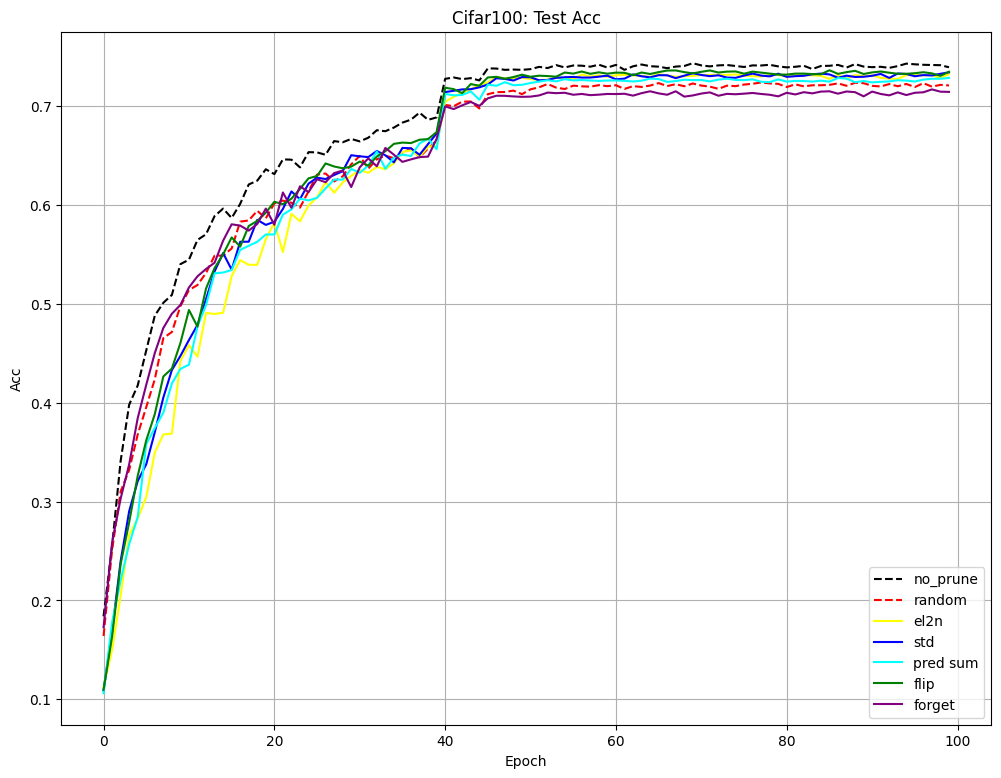

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget
markers = ('dashed', 'solid')

labels = {
    'no_prune': 'no_prune',
    'prune_25p_random': 'random',
    'prune_25p_el2n': 'el2n',
    'prune_25p_std': 'std',
    'prune_25p_pred_sum': 'pred sum',
    'prune_25p_forget': 'flip',
    'prune_25p_true_forget': 'forget',
}
plt.figure(figsize=(12, 9))
for i, model in enumerate(models):
    plt.plot(range(model.data['epochs']), model.data['valid']['acc'], label=labels[model.name],
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()

50 100
no_prune 0.6769670000000015
50 100
prune_25p_random 0.650660000000001
50 100
prune_25p_el2n 0.6414040000000011
50 100
prune_25p_std 0.6496480000000011
50 100
prune_25p_pred_sum 0.6433360000000008
50 100
prune_25p_forget 0.6538700000000008
50 100
prune_25p_true_forget 0.6472920000000011


<Figure size 1200x900 with 0 Axes>

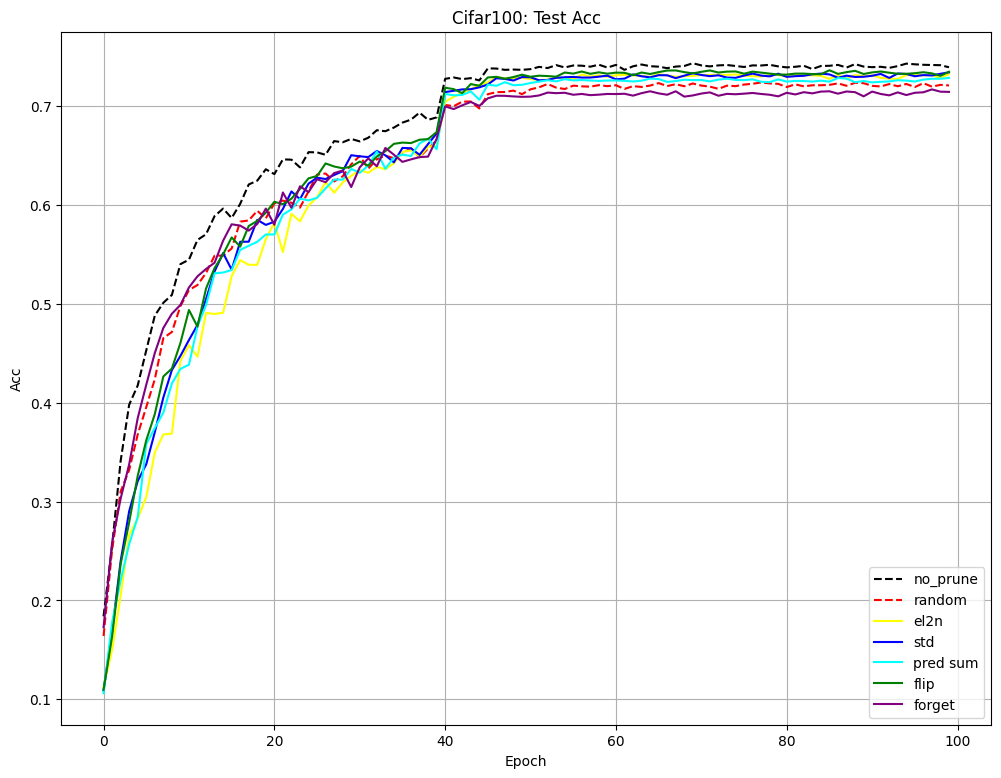

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget
markers = ('dashed', 'solid')

labels = {
    'no_prune': 'no_prune',
    'prune_25p_random': 'random',
    'prune_25p_el2n': 'el2n',
    'prune_25p_std': 'std',
    'prune_25p_pred_sum': 'pred sum',
    'prune_25p_forget': 'flip',
    'prune_25p_true_forget': 'forget',
}
save = {}
epochs_idx = np.arange(EPOCHS*2)
plt.figure(figsize=(12, 9))
for i, model in enumerate(models):
    model_valid_acc = np.array(model.data['valid']['acc'])
    plt.plot(epochs_idx, model_valid_acc, label=labels[model.name],
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
    print(model.name, np.mean(model_valid_acc))
    save[labels[model.name]] = model_valid_acc

plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()



In [25]:
save

{'no_prune': array([0.1839, 0.2551, 0.3411, 0.3981, 0.4175, 0.453 , 0.4882, 0.5012,
        0.5091, 0.5403, 0.5448, 0.5648, 0.5705, 0.5889, 0.5965, 0.587 ,
        0.6013, 0.6209, 0.6248, 0.6363, 0.6314, 0.6463, 0.646 , 0.6382,
        0.6536, 0.6534, 0.6509, 0.6648, 0.6636, 0.667 , 0.6645, 0.6682,
        0.6758, 0.6748, 0.6785, 0.6835, 0.6865, 0.6936, 0.6863, 0.6888,
        0.7278, 0.7292, 0.7275, 0.7285, 0.7262, 0.7384, 0.7382, 0.7369,
        0.7372, 0.7369, 0.7376, 0.7399, 0.7387, 0.7417, 0.7393, 0.7413,
        0.7411, 0.7401, 0.7421, 0.7392, 0.7419, 0.7369, 0.7405, 0.7423,
        0.7406, 0.7401, 0.7386, 0.7402, 0.7408, 0.7436, 0.7414, 0.7404,
        0.7414, 0.7418, 0.7408, 0.7398, 0.7414, 0.7413, 0.742 , 0.7404,
        0.7394, 0.74  , 0.741 , 0.7377, 0.7408, 0.741 , 0.7419, 0.7392,
        0.7427, 0.7402, 0.7396, 0.74  , 0.7389, 0.7407, 0.7432, 0.7425,
        0.742 , 0.7418, 0.7416, 0.7395]),
 'random': array([0.164 , 0.2511, 0.3103, 0.3319, 0.3679, 0.3956, 0.4238, 0.4655,


In [26]:
import pickle

with open('25', 'wb') as f:
    pickle.dump(save, f)